In [19]:
import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

from data_loader.data_loaders import get_data_loaders, get_layered_data_loaders
from model.model import InstrumentClassifier, LayeredInstrumentClassifier

device = 'cuda' if torch.cuda.is_available() else 'cpu'

base_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'dataset'))

In [20]:
train_loader, test_loader, val_loader = get_data_loaders(base_path=base_path, batch_size=32, duration=12)

model = InstrumentClassifier(num_classes=4).to(device)
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

c:\Users\trema\anaconda3\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
c:\Users\trema\anaconda3\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
c:\Users\trema\anaconda3\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


InstrumentClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [21]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Confusion Matrix:
[[13  0  0  7]
 [ 1 13  0  6]
 [ 0  5  0 15]
 [ 0  1  0 19]]


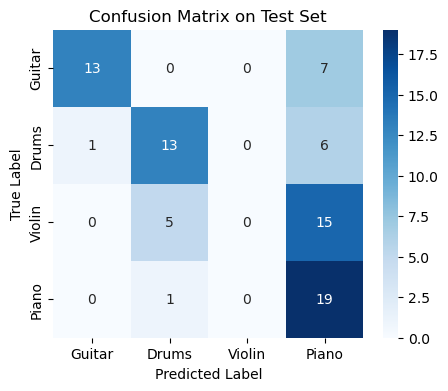

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Guitar','Drums','Violin','Piano'],
            yticklabels=['Guitar','Drums','Violin','Piano'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [23]:
print("Classification Report:")
print(classification_report(all_labels, all_preds,
      target_names=['Guitar','Drums','Violin','Piano']))

Classification Report:
              precision    recall  f1-score   support

      Guitar       0.93      0.65      0.76        20
       Drums       0.68      0.65      0.67        20
      Violin       0.00      0.00      0.00        20
       Piano       0.40      0.95      0.57        20

    accuracy                           0.56        80
   macro avg       0.50      0.56      0.50        80
weighted avg       0.50      0.56      0.50        80



c:\Users\trema\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\trema\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\trema\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


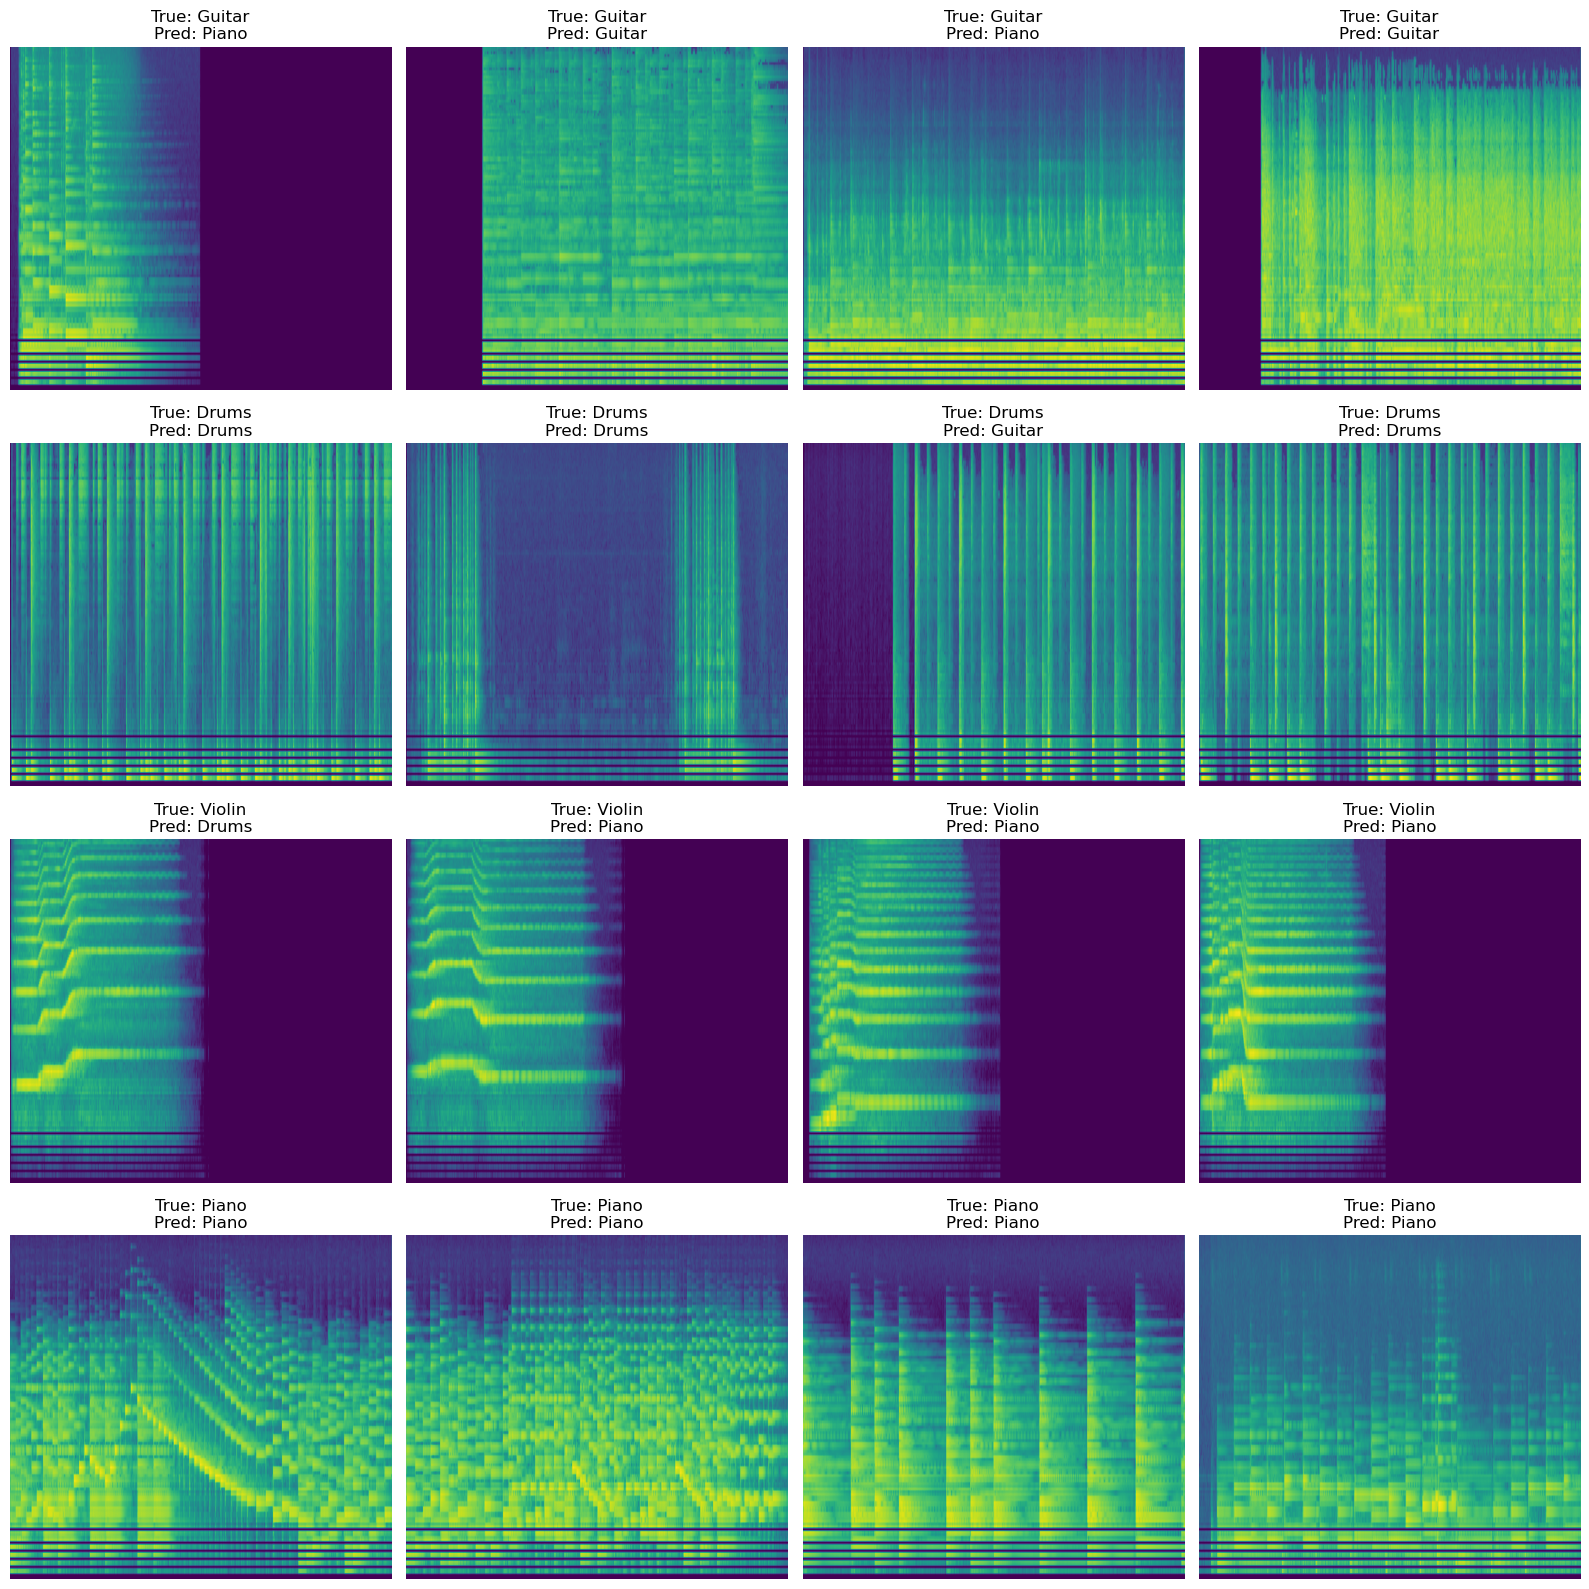

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class_names = ['Guitar', 'Drums', 'Violin', 'Piano']

results = {0: [], 1: [], 2: [], 3: []}

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for img, true_label, pred in zip(inputs.cpu(), labels.cpu(), predicted.cpu()):
            true_label = true_label.item()
            if len(results[true_label]) < 4:
                results[true_label].append((img, true_label, pred.item()))
        if all(len(v) >= 4 for v in results.values()):
            break

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for class_idx in range(4):
    for sample_idx in range(4):
        ax = axes[class_idx, sample_idx]
        if sample_idx < len(results[class_idx]):
            img, true_label, pred_label = results[class_idx][sample_idx]
            img = img.squeeze(0).numpy()
            ax.imshow(img, aspect='auto', origin='lower', cmap='viridis')
            ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
        ax.axis('off')

plt.tight_layout()
plt.show()

Now For layered Instruments:

In [25]:
train_loader, test_loader, val_loader, num_classes = get_layered_data_loaders('C:\\Users\\trema\\Data Science\\DSCI 410 project\\dataset', batch_size=32, duration=12, n_layers=2)
model = LayeredInstrumentClassifier(num_classes=4).to(device)
model.load_state_dict(torch.load('best_model_layered.pth', map_location=device))
model.eval()

c:\Users\trema\anaconda3\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
c:\Users\trema\anaconda3\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
c:\Users\trema\anaconda3\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


LayeredInstrumentClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [26]:
from sklearn.metrics import f1_score

all_preds_layered = []
all_labels_layered = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) >= 0.5).int()
        all_preds_layered.append(preds.cpu().numpy())
        all_labels_layered.append(labels.cpu().numpy())

all_preds_layered = np.concatenate(all_preds_layered, axis=0)
all_labels_layered = np.concatenate(all_labels_layered, axis=0)

f1_micro = f1_score(all_labels_layered, all_preds_layered, average='micro', zero_division=0)
f1_macro = f1_score(all_labels_layered, all_preds_layered, average='macro', zero_division=0)

print(f"Micro F1-score (layered):  {f1_micro:.4f}")
print(f"Macro F1-score (layered):  {f1_macro:.4f}")

Micro F1-score (layered):  0.5338
Macro F1-score (layered):  0.4838


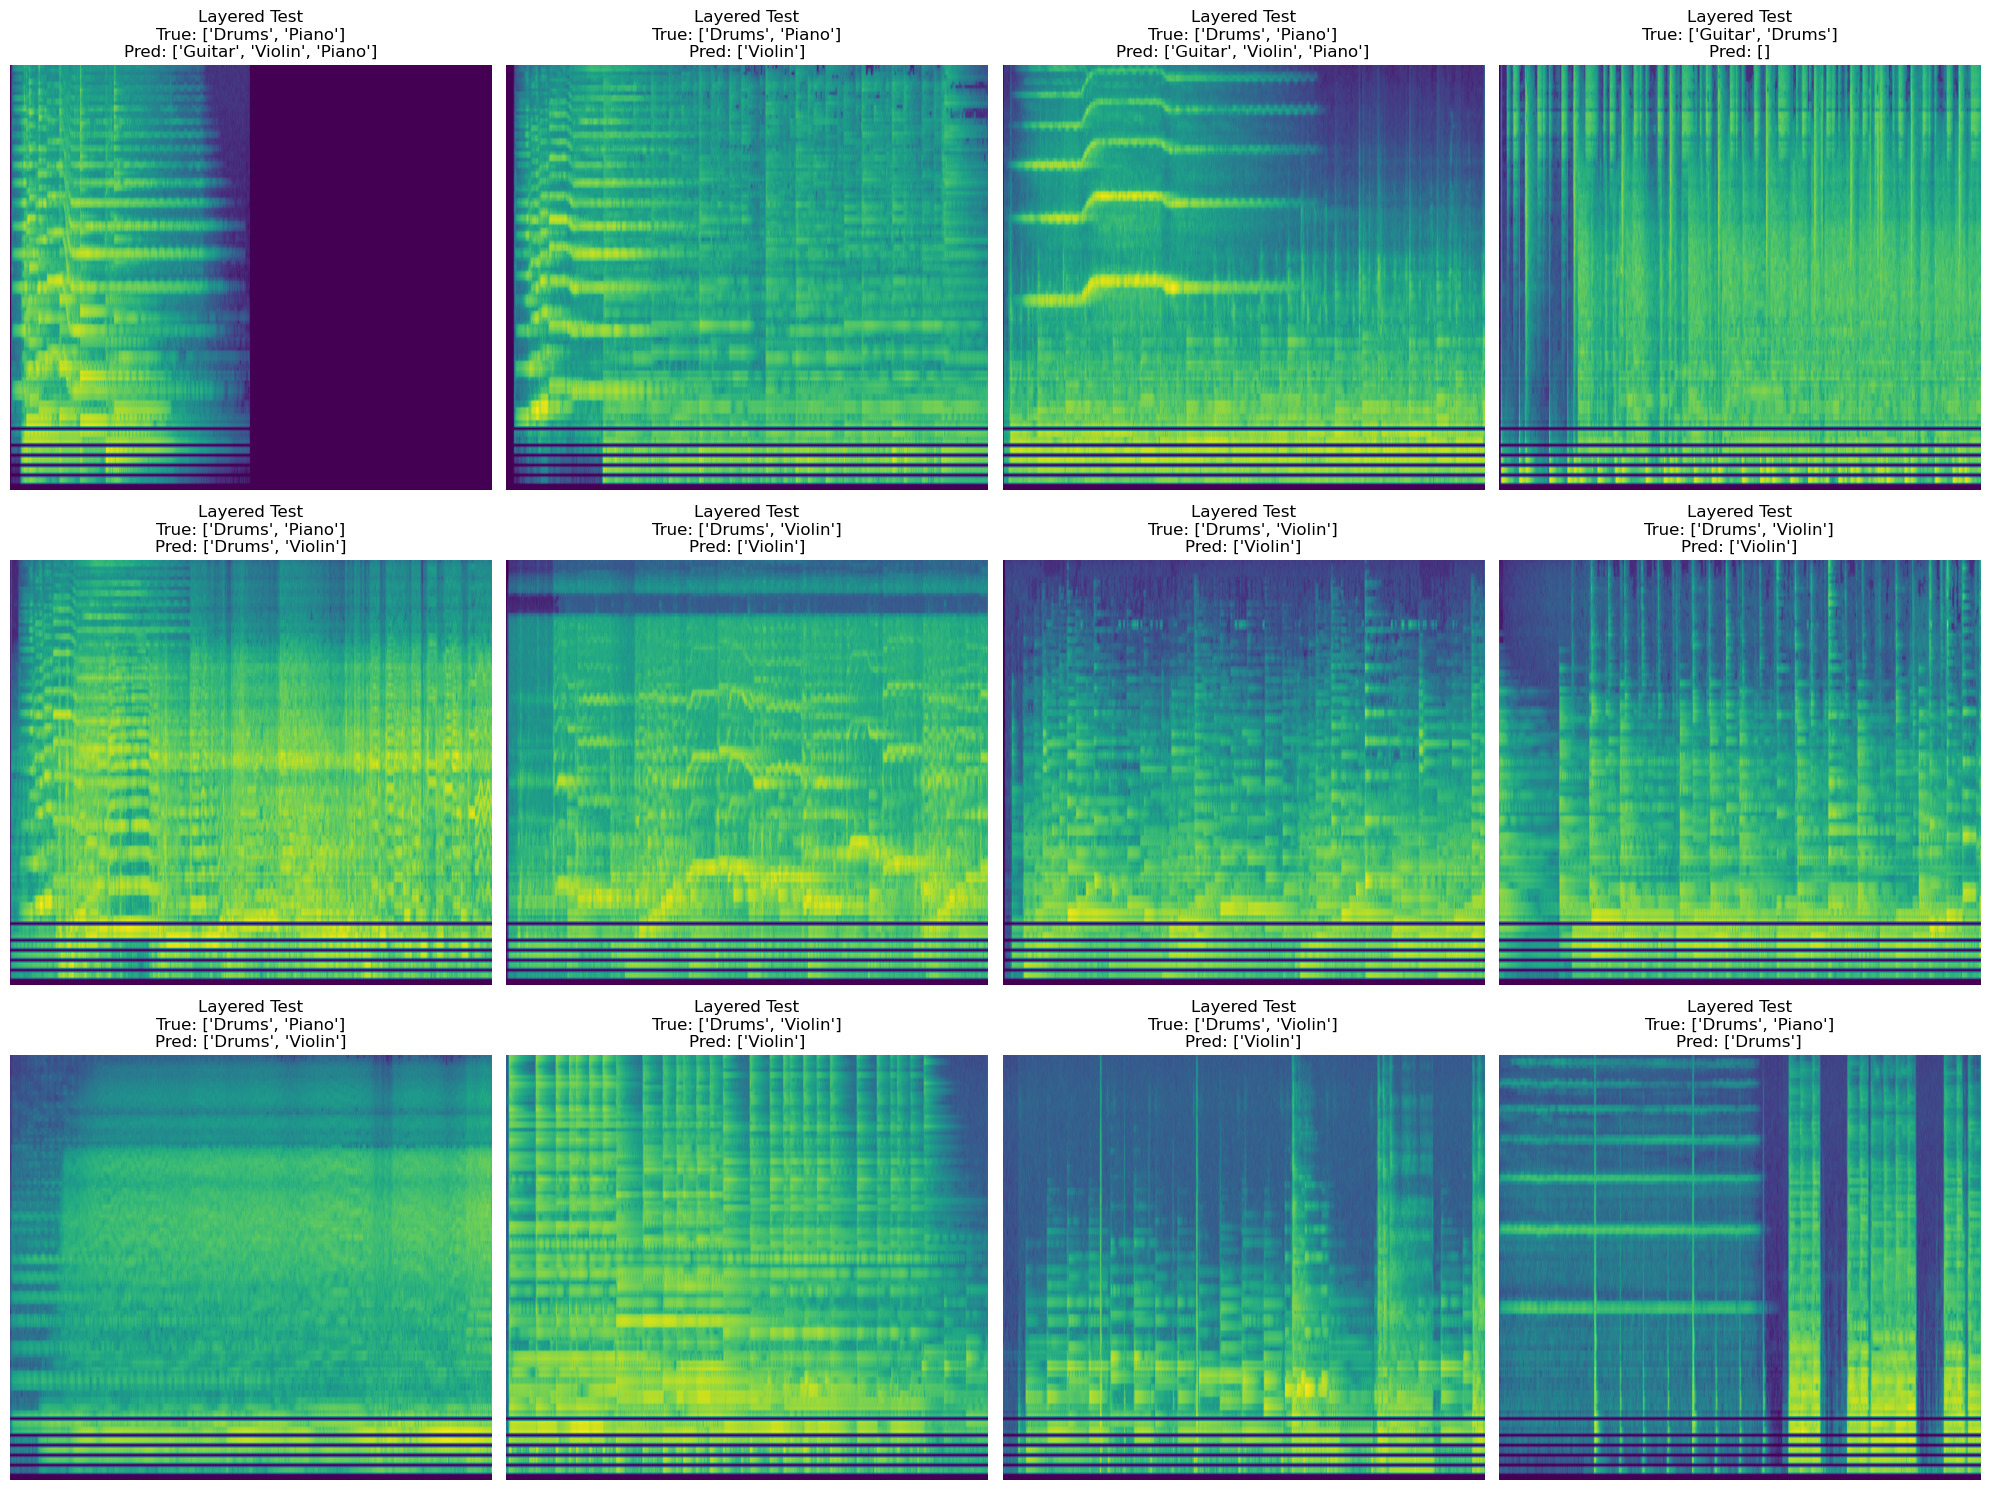

In [27]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = (torch.sigmoid(outputs) >= 0.5).int()

inv_class_map = {0: 'Guitar', 1: 'Drums', 2: 'Violin', 3: 'Piano'}

num_samples = min(images.size(0), 12)
cols = 4
rows = (num_samples + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for i in range(num_samples):
    img = images[i].cpu().squeeze(0).numpy()

    true_indices = np.where(labels[i].numpy() == 1)[0]
    pred_indices = np.where(preds[i].cpu().numpy() == 1)[0]
    
    true_instruments = [inv_class_map[idx] for idx in true_indices]
    pred_instruments = [inv_class_map[idx] for idx in pred_indices]
    
    axes[i].imshow(img, aspect='auto', origin='lower', cmap='viridis')
    axes[i].set_title(f"Layered Test\nTrue: {true_instruments}\nPred: {pred_instruments}")
    axes[i].axis('off')

for j in range(num_samples, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Now Evaluating my Chosen songs:

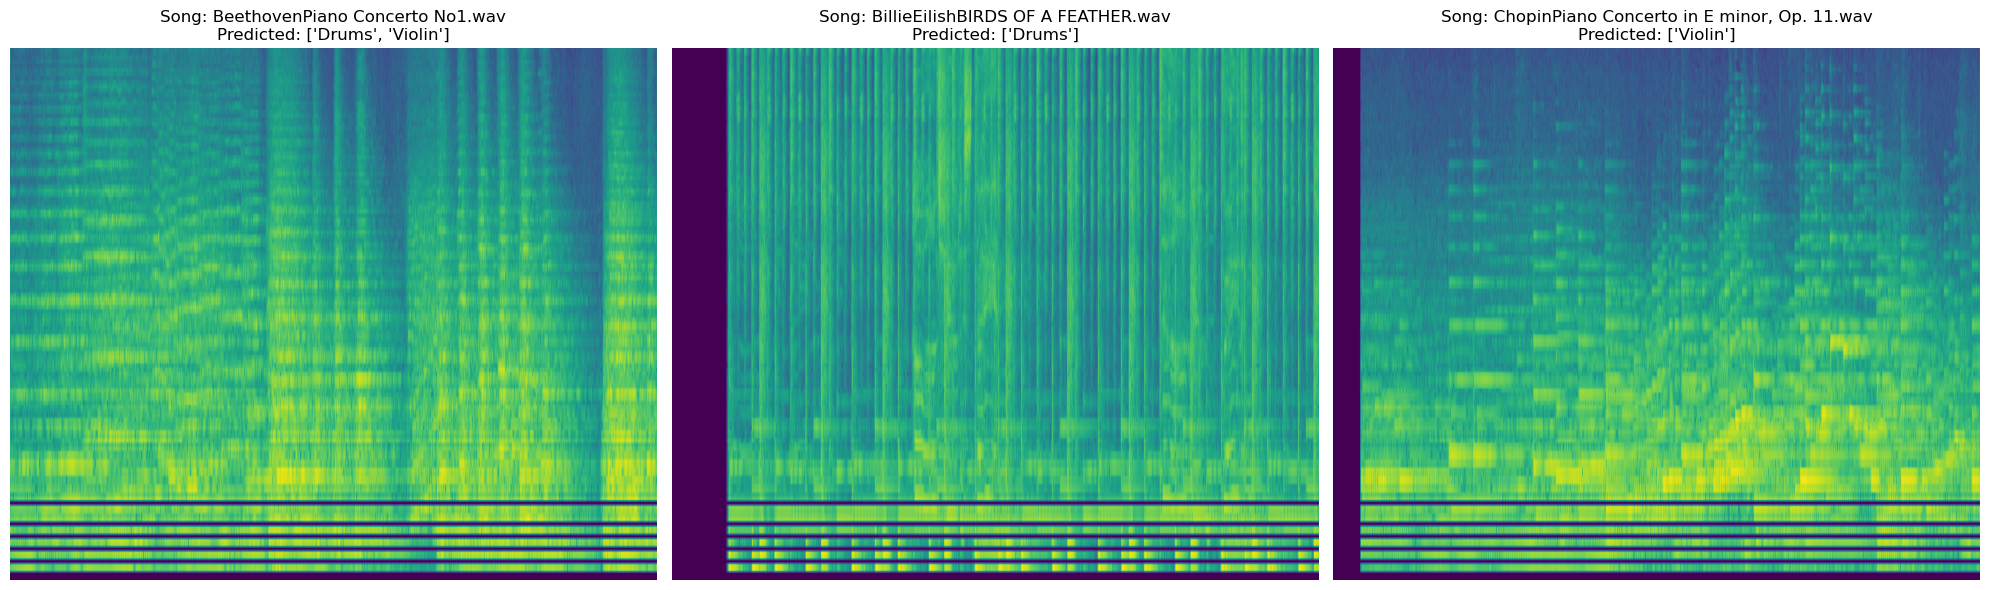

In [31]:
import torchaudio

def process_song(song_path, sample_rate=22050, fixed_length=12, n_mels=128):
    waveform, sr = torchaudio.load(song_path)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
        
    target_samples = sample_rate * fixed_length
    num_samples = waveform.shape[1]

    if num_samples > target_samples:
        waveform = waveform[:, :target_samples]
    else:
        pad_length = target_samples - num_samples
        waveform = F.pad(waveform, (0, pad_length))

    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)
    db_transform = torchaudio.transforms.AmplitudeToDB()
    mel_spec = mel_transform(waveform)
    mel_spec = db_transform(mel_spec)

    mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-6)
    return mel_spec

song_paths = [
    r"C:\\Users\\trema\\Data Science\\DSCI 410 project\\BeethovenPiano Concerto No1.wav",
    r"C:\\Users\\trema\\Data Science\\DSCI 410 project\\BillieEilishBIRDS OF A FEATHER.wav",
    r"C:\\Users\\trema\\Data Science\\DSCI 410 project\\ChopinPiano Concerto in E minor, Op. 11.wav"
]


model.eval()
inv_class_map = {0: 'Guitar', 1: 'Drums', 2: 'Violin', 3: 'Piano'}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, song in enumerate(song_paths):
    mel_spec = process_song(song)
    input_tensor = mel_spec.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred = (torch.sigmoid(output) >= 0.5).int().cpu().numpy()[0]

    predicted_instruments = [inv_class_map[j] for j, v in enumerate(pred) if v == 1]
    img = mel_spec.squeeze(0).cpu().numpy()
    axes[i].imshow(img, aspect='auto', origin='lower', cmap='viridis')
    axes[i].set_title(f"Song: {os.path.basename(song)}\nPredicted: {predicted_instruments}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()